In [30]:
from unstructured.partition.pdf import partition_pdf
# import pytesseract
# pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"
# output_path = "./content/"
file_path = r"S:\LLM\RAG\data\pdf_test\1706.03762v7.pdf"

# Reference: https://docs.unstructured.io/open-source/core-functionality/chunking
chunks = partition_pdf(
    filename=file_path,
    infer_table_structure=True,            # extract tables
    strategy="hi_res",                     # mandatory to infer tables

    extract_image_block_types=["Image"],   # Add 'Table' to list to extract image of tables
    # image_output_dir_path=output_path,   # if None, images and tables will saved in base64

    extract_image_block_to_payload=True,   # if true, will extract base64 for API usage

    chunking_strategy="by_title",          # or 'basic'
    max_characters=10000,                  # defaults to 500
    combine_text_under_n_chars=2000,       # defaults to 0
    new_after_n_chars=6000,

    # extract_images_in_pdf=True,          # deprecated
)

In [31]:
# separate tables from texts
tables = []
texts = []

for chunk in chunks:
    if "Table" in str(type(chunk)):
        tables.append(chunk)

    for elem in chunk.metadata.orig_elements:
        if "Table" in str(type(elem)): tables.append(elem)

    if "CompositeElement" in str(type((chunk))):
        texts.append(chunk)

In [ ]:
# for chunk in chunks :
#     print(len(chunk.metadata.orig_elements))
#     for elem in chunk.metadata.orig_elements:
#         if "Table" in str(type(elem)): 
#             print(type(elem))
#             for elem2 in chunk.metadata.orig_elements:
#                 print(type(elem2))
#     print("\n\n")

In [34]:
# Get the images from the CompositeElement objects
def get_images_base64(chunks):
    images_b64 = []
    for chunk in chunks:
        if "CompositeElement" in str(type(chunk)):
            chunk_els = chunk.metadata.orig_elements
            for el in chunk_els:
                if "Image" in str(type(el)):
                    images_b64.append(el.metadata.image_base64)
    return images_b64

images = get_images_base64(chunks)

In [35]:
from langchain_community.chat_models import ChatOllama
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

In [5]:
# Prompt
prompt_text = """
You are an assistant tasked with summarizing tables and text.
Give a concise summary of the table or text.

Respond only with the summary, no additionnal comment.
Do not start your message by saying "Here is a summary" or anything like that.
Just give the summary as it is.

Table or text chunk: {element}

"""
prompt = ChatPromptTemplate.from_template(prompt_text)

# Summary chain
model = ChatOllama(temperature=0.5, 
                   model='phi3.5',
                   keep_alive=0,
                   max_tokens=512)

summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

C:\Users\keith\AppData\Local\Temp\ipykernel_41920\2760874657.py:16: LangChainDeprecationWarning: The class `ChatOllama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import ChatOllama``.
  model = ChatOllama(temperature=0.5,


In [26]:
# Summarize text
text_summaries = summarize_chain.batch(texts, {"max_concurrency": 3})

# Summarize tables
tables_html = [table.metadata.text_as_html for table in tables]
table_summaries = summarize_chain.batch(tables_html, {"max_concurrency": 3})

In [37]:
text_summaries
table_summaries

['1. Self-Attention: Complexity O(n*d), Sequential Operations in constant time, Maximum Path Length also at O(1).\n2. Recurrent: Time complexity varies between O(n) and n depending on d; sequential operations take linear time with respect to input length; maximum path is of the same order as input size (O(n)).\n3. Convolutional: Complexity depends on k, number of neurons in a filter/kernel; operational complexity remains constant at O(1); max path grows logarithmically relative to n (logy(n)).\n4. Self-Attention with restricted context window: Similar logic as standard self-attention but considers r elements for the attention mechanism, resulting in time and maximum length complexities of O(r*n) and O(n/r), respectively; operational complexity is not specified (ol).',
 'Models compared with EN-DE, EN-FR BLEU scores and training costs (FLOPs): ByteNet [18] at 23.75; Deep-Att + PosUnk scored highest in both languages but lack data on FLOPs; GNMT+RL shows improvement over single models wi

In [38]:
prompt_template = """Describe the image in detail. For context,
                  the image is part of a research paper explaining the transformers
                  architecture. Be specific about graphs, such as bar plots."""
messages = [
    (
        "user",
        [
            {"type": "text", "text": prompt_template},
            {
                "type": "image_url",
                "image_url": {"url": "data:image/jpeg;base64,{image}"},
            },
        ],
    )
]

prompt = ChatPromptTemplate.from_messages(messages)

chain = prompt | ChatOllama(model="llava-phi3", keep_alive=0) | StrOutputParser()


image_summaries = chain.batch(images)

In [39]:
image_summaries

['The image presents a flowchart that serves as an explanation for Transformer architectures in machine learning models. The chart illustrates how different types of data inputs and outputs are processed within the model. Here\'s a detailed description:\n\n1. At the top, there\'s a **gray rectangle** labeled "**Out**" representing the output of the entire model.\n2. Below it, three **blue rectangles** stacked vertically represent different types of inputs to the model. From bottom to top:\n\t* The first rectangle is labeled "**Input Embedding**", indicating an embedding for a sequence of integers.\n\t* The middle rectangle is labeled "**Multi-Head Attention**" with a **red background**, signifying attention to words in the input sequence.\n\t* The topmost rectangle is labeled "**Output (with 1 head)**", representing an output for a single word prediction task.\n3. To the right of these rectangles, there\'s a **yellow rectangle** with two blue arrows pointing towards it from different d

In [41]:
import uuid
from langchain.vectorstores import Chroma
from langchain.storage import InMemoryStore
from langchain.schema.document import Document
from langchain_community.embeddings import OllamaEmbeddings
from langchain.retrievers.multi_vector import MultiVectorRetriever

# # Create embeddingsclear
embeddings = OllamaEmbeddings(model="nomic-embed-text", show_progress=True)

# The vectorstore to use to index the child chunks
vectorstore = Chroma(collection_name="multi_modal_rag", 
                     embedding_function=embeddings,
                     persist_directory="./db-test"
                     )

# The storage layer for the parent documents
store = InMemoryStore()
id_key = "doc_id"

# The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key,
)

C:\Users\keith\AppData\Local\Temp\ipykernel_41920\379359868.py:9: LangChainDeprecationWarning: The class `OllamaEmbeddings` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import OllamaEmbeddings``.
  embeddings = OllamaEmbeddings(model="nomic-embed-text", show_progress=True)
C:\Users\keith\AppData\Local\Temp\ipykernel_41920\379359868.py:12: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectorstore = Chroma(collection_name="multi_modal_rag",


In [42]:
# Add texts
doc_ids = [str(uuid.uuid4()) for _ in texts]
summary_texts = [
    Document(page_content=summary, metadata={id_key: doc_ids[i]}) for i, summary in enumerate(text_summaries)
]
retriever.vectorstore.add_documents(summary_texts)
retriever.docstore.mset(list(zip(doc_ids, texts)))

# Add tables
table_ids = [str(uuid.uuid4()) for _ in tables]
summary_tables = [
    Document(page_content=summary, metadata={id_key: table_ids[i]}) for i, summary in enumerate(table_summaries)
]
retriever.vectorstore.add_documents(summary_tables)
retriever.docstore.mset(list(zip(table_ids, tables)))

# Add image summaries
img_ids = [str(uuid.uuid4()) for _ in images]
summary_img = [
    Document(page_content=summary, metadata={id_key: img_ids[i]}) for i, summary in enumerate(image_summaries)
]
retriever.vectorstore.add_documents(summary_img)
retriever.docstore.mset(list(zip(img_ids, images)))

OllamaEmbeddings: 100%|██████████| 7/7 [00:14<00:00,  2.07s/it]


In [43]:
# Example Retrieve
docs = retriever.invoke(
    "who are the authors of the paper?"
)
for doc in docs:
    print(str(doc) + "\n\n" + "-" * 80)

OllamaEmbeddings: 100%|██████████| 1/1 [00:02<00:00,  2.05s/it]

3

2023

2

0

2

g u A 2 ] L C . s c [ 7 v 2 6 7 3 0 . 6 0

7

1

:

v

arXiv

i

X

r

a

Provided proper attribution is provided, Google hereby grants permission to reproduce the tables and figures in this paper solely for use in journalistic or scholarly works.

Attention Is All You Need

Ashish Vaswani∗

Google Brain

avaswani@google.com

Noam Shazeer∗ Google Brain noam@google.com

Niki Parmar∗ Google Research nikip@google.com

Jakob Uszkoreit∗

Google Research usz@google.com

Llion Jones∗

Google Research llion@google.com

Aidan N. Gomez∗ † University of Toronto aidan@cs.toronto.edu

Łukasz Kaiser∗ Google Brain lukaszkaiser@google.com

Illia Polosukhin∗ ‡

illia.polosukhin@gmail.com

Abstract

The dominant sequence transduction models are based on complex recurrent or convolutional neural networks that include an encoder and a decoder. The best performing models also connect the encoder and decoder through an attention mechanism. We propose a new simple network architecture, the 

In [47]:
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.messages import SystemMessage, HumanMessage
# from langchain_openai import ChatOpenAI
from base64 import b64decode


def parse_docs(docs):
    """Split base64-encoded images and texts"""
    b64 = []
    text = []
    for doc in docs:
        try:
            b64decode(doc)
            b64.append(doc)
        except Exception as e:
            text.append(doc)
    return {"images": b64, "texts": text}


def build_prompt(kwargs):

    docs_by_type = kwargs["context"]
    user_question = kwargs["question"]

    context_text = ""
    if len(docs_by_type["texts"]) > 0:
        for text_element in docs_by_type["texts"]:
            context_text += text_element.text

    # construct prompt with context (including images)
    prompt_template = f"""
    Answer the question based only on the following context, which can include text, tables, and the below image.
    Context: {context_text}
    Question: {user_question}
    """

    prompt_content = [{"type": "text", "text": prompt_template}]

    if len(docs_by_type["images"]) > 0:
        for image in docs_by_type["images"]:
            # print(image)
            prompt_content.append(
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{image}"},
                }
            )

    return ChatPromptTemplate.from_messages(
        [
            HumanMessage(content=prompt_content),
        ]
    )


chain = (
    {
        "context": retriever | RunnableLambda(parse_docs),
        "question": RunnablePassthrough(),
    }
    | RunnableLambda(build_prompt)
    | ChatOllama(model="llava-phi3", keep_alive=0)
    | StrOutputParser()
)

chain_with_sources = {
    "context": retriever | RunnableLambda(parse_docs),
    "question": RunnablePassthrough(),
} | RunnablePassthrough().assign(
    response=(
        RunnableLambda(build_prompt)
        | ChatOllama(model="llava-phi3", keep_alive=0)
        | StrOutputParser()
    )
)

In [50]:
response = chain.invoke(
    "How does multi-head attention mechanism works within the Transformer model?"
    # "What is the attention mechanism?"
)

print(response)

OllamaEmbeddings: 100%|██████████| 1/1 [00:02<00:00,  2.07s/it]


/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAHYA4UDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD0KHxFq3ifxxrmhaVqMGmW2iiJZHMAlluJHBJwGOFRcY6ZOeorS8O3/iQeKdV0nxA1nJFDbwy2U9rEYxKpZw5YFjhuFBGcDt1rnfGfw4vr7XT4v8F6t/Z2v7cSLn91c4GMHqAcAA5BBwM461N4F+JFxrI1XS/EenGw8QaPE0lz

In [53]:
import base64
from IPython.display import Image, display

def display_base64_image(base64_code):
    # Decode the base64 string to binary
    image_data = base64.b64decode(base64_code)
    # Display the image
    display(Image(data=image_data))

OllamaEmbeddings: 100%|██████████| 1/1 [00:02<00:00,  2.07s/it]


/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAHYA4UDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD0KHxFq3ifxxrmhaVqMGmW2iiJZHMAlluJHBJwGOFRcY6ZOeorS8O3/iQeKdV0nxA1nJFDbwy2U9rEYxKpZw5YFjhuFBGcDt1rnfGfw4vr7XT4v8F6t/Z2v7cSLn91c4GMHqAcAA5BBwM461N4F+JFxrI1XS/EenGw8QaPE0lz

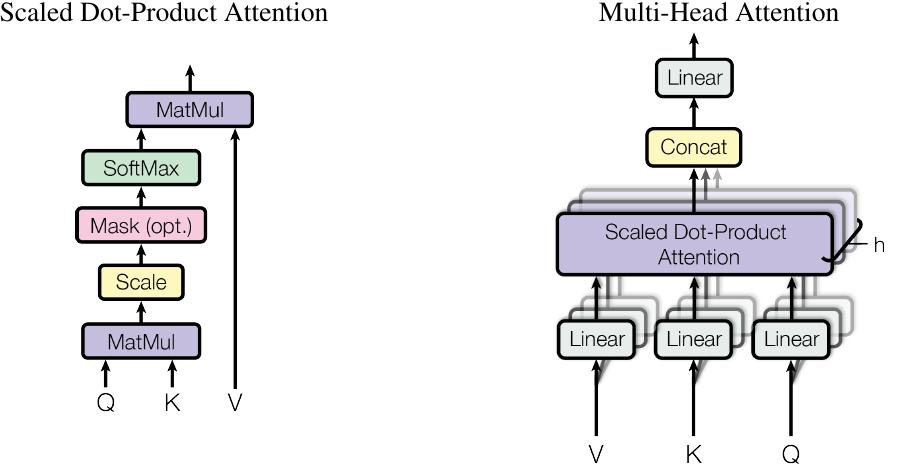

In [54]:
response = chain_with_sources.invoke(
    "How does multi-head attention mechanism works within the Transformer model?"
)

print("Response:", response['response'])

print("\n\nContext:")
for text in response['context']['texts']:
    print(text.text)
    print("Page number: ", text.metadata.page_number)
    print("\n" + "-"*50 + "\n")
for image in response['context']['images']:
    display_base64_image(image)